In [1]:
# Cell 1: Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization, LayerNormalization, Reshape, Permute, Bidirectional, Add, Attention, Flatten, TimeDistributed, Conv2DTranspose, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.layers import Layer, Concatenate
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score
import librosa
import soundfile as sf
import noisereduce as nr
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
import logging  # Import the logging module
from tqdm.notebook import tqdm # Use tqdm.notebook for better Jupyter integration

# Add these lines:
import random

# Add this to create a directory for saving figures
FIGURES_DIR = 'training_figures'
os.makedirs(FIGURES_DIR, exist_ok=True)

# Configure logging to a file (optional, but recommended)
logging.basicConfig(filename='audio_errors.log', level=logging.ERROR,
                    format='%(asctime)s - %(levelname)s - %(message)s')

print(f"TensorFlow version: {tf.__version__}") # Check the TF version to verify install

2025-03-31 23:45:32.577586: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 23:45:32.633727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743444932.679191  113978 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743444932.687672  113978 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743444932.744282  113978 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0


In [2]:
# Cell 2: Force GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(f"Error configuring GPU: {e}")
else:
    print("No GPU devices found.  Falling back to CPU.")

GPU is available and configured.


In [3]:
# Cell 3: Audio Loading and Preprocessing Function
def load_and_preprocess_audio(file_path, sr=16000, duration=4):
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Data Augmentation (increased probability and variety)
        if np.random.random() < 0.5:  # 50% chance of applying augmentation
            augmentation_type = np.random.choice(['noise', 'pitch', 'speed'])
            if augmentation_type == 'noise':
                noise = np.random.randn(len(audio)) * 0.005
                audio = audio + noise
            elif augmentation_type == 'pitch':
                audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.uniform(-2, 2))
            else:  # speed
                audio = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.8, 1.2))

        # Normalize audio
        audio = audio - np.mean(audio)
        audio = audio / np.max(np.abs(audio))

        # Pad if necessary
        if len(audio) < sr * duration:
            audio = np.pad(audio, (0, sr * duration - len(audio)))
        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

In [4]:
# Cell 4: Feature Extraction Function
def extract_features(audio, sr=16000, n_mels=80, n_fft=2048, hop_length=512):
    if audio is None:
        return None

    # Extract mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize features
    log_mel_spec = (log_mel_spec - np.mean(log_mel_spec)) / np.std(log_mel_spec)
    return log_mel_spec

In [5]:
# Cell 5: Class Distribution Analysis Function
def analyze_class_distribution(data_path):
    real_count = len([f for f in os.listdir(os.path.join(data_path, 'real')) if f.endswith('.wav')])
    fake_count = len([f for f in os.listdir(os.path.join(data_path, 'fake')) if f.endswith('.wav')])
    total = real_count + fake_count
    print(f"\nClass Distribution for {data_path}:")
    print(f"Real: {real_count} ({real_count/total*100:.2f}%)")
    print(f"Fake: {fake_count} ({fake_count/total*100:.2f}%)")
    return {'real': real_count, 'fake': fake_count}

In [6]:
# Define the fixed number of frames for GAN consistency
TARGET_FRAMES = 126 # Calculated based on sr=16000, duration=4, hop_length=512

# Data generator with sample weights and FIXED padding
def data_generator(data_path, batch_size=128, shuffle=True, target_frames=TARGET_FRAMES):
    real_files = [os.path.join(data_path, 'real', f) for f in os.listdir(os.path.join(data_path, 'real')) if f.endswith('.wav')]
    fake_files = [os.path.join(data_path, 'fake', f) for f in os.listdir(os.path.join(data_path, 'fake')) if f.endswith('.wav')]

    all_files = real_files + fake_files
    labels = [1] * len(real_files) + [0] * len(fake_files)

    total_samples = len(all_files)
    class_weights = {
        1: total_samples / (2 * len(real_files)),
        0: total_samples / (2 * len(fake_files))
    }

    while True:
        if shuffle:
            temp = list(zip(all_files, labels))
            np.random.shuffle(temp)
            all_files, labels = zip(*temp)

        for i in range(0, len(all_files), batch_size):
            batch_files = all_files[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            batch_x = []
            batch_y = []
            batch_weights = []
            # max_length = 0 # No longer needed for fixed padding

            for file_path, label in zip(batch_files, batch_labels):
                audio = load_and_preprocess_audio(file_path)
                features = extract_features(audio) # Shape (80, n_frames)

                if features is not None:
                    # Pad or truncate features to target_frames
                    current_frames = features.shape[1]
                    if current_frames < target_frames:
                        pad_width = target_frames - current_frames
                        padded_features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
                    else:
                        padded_features = features[:, :target_frames] # Truncate if longer

                    batch_x.append(padded_features) # Append the (80, target_frames) array
                    batch_y.append(label)
                    weight = class_weights[label]
                    batch_weights.append(weight)
                    # max_length = max(max_length, features.shape[1]) # No longer needed

            # No need for secondary padding loop as all are now (80, target_frames)
            if batch_x:
                # Add channel dimension for Conv2D discriminator
                batch_x_4d = np.expand_dims(np.array(batch_x), axis=-1)
                yield batch_x_4d, np.array(batch_y), np.array(batch_weights)


def data_generator_GAN(data_path, batch_size=128, shuffle=True, target_frames=TARGET_FRAMES):
    """Generates batches of audio features for SPOOF samples only, with FIXED padding."""
    fake_files = [os.path.join(data_path, 'fake', f) for f in os.listdir(os.path.join(data_path, 'fake')) if f.endswith('.wav')]

    while True:
        if shuffle:
            np.random.shuffle(fake_files)

        for i in range(0, len(fake_files), batch_size):
            batch_files = fake_files[i:i+batch_size]
            batch_x = []
            # max_length = 0 # No longer needed

            for file_path in batch_files:
                audio = load_and_preprocess_audio(file_path)

                if audio is None:
                    print(f"Skipping {file_path} due to loading failure.")
                    continue

                features = extract_features(audio) # Shape (80, n_frames)

                if features is None:
                    print(f"Skipping {file_path} due to feature extraction failure.")
                    continue

                # Pad or truncate features to target_frames
                current_frames = features.shape[1]
                if current_frames < target_frames:
                    pad_width = target_frames - current_frames
                    padded_features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    padded_features = features[:, :target_frames] # Truncate if longer

                batch_x.append(padded_features)
                # max_length = max(max_length, features.shape[1]) # No longer needed

            # No need for secondary padding loop
            if batch_x:
                # Add channel dimension before yielding
                padded_batch_x_4d = np.expand_dims(np.array(batch_x), axis=-1)
                yield padded_batch_x_4d # Yield 4D array (batch, 80, target_frames, 1)

In [7]:
# Cell 7: Modified MFM layer
class MFM(Layer):
    def __init__(self, **kwargs):
        super(MFM, self).__init__(**kwargs)

    def call(self, inputs):
        shape = tf.shape(inputs)
        return tf.reshape(tf.math.maximum(inputs[:,:,:shape[-1]//2], inputs[:,:,shape[-1]//2:]), (shape[0], shape[1], shape[-1]//2))

In [8]:
def create_generator(latent_dim, output_shape): # output_shape should be (n_mels, n_frames) e.g., (80, 126)
    """Creates the generator model designed to output the correct spectrogram shape."""
    n_mels, n_frames = output_shape
    target_shape_with_channel = (n_mels, n_frames, 1)

    model = tf.keras.Sequential()

    # Start dense layer - aim for dimensions that allow upsampling to target
    # Let's target initial dimensions like (5, 8) before upsampling
    # Strides of 2, 3 times: 2*2*2 = 8. Height: 80/8 = 10. Width: 126/8 approx 16.
    # Let's try initial shape (10, 16) with 128 filters? -> 10*16*128 = 20480 nodes
    nodes = 10 * 16 * 128
    model.add(Dense(nodes, input_dim=latent_dim))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(Reshape((10, 16, 128))) # H=10, W=16, C=128

    # Upsample 1: (10, 16, 128) -> (20, 32, 64)
    model.add(Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(LayerNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    # Upsample 2: (20, 32, 64) -> (40, 64, 32)
    model.add(Conv2DTranspose(32, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(LayerNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    # Upsample 3: (40, 64, 32) -> (80, 128, 1) - Width is too large (128 vs 126)
    model.add(Conv2DTranspose(1, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='tanh'))

    # Add a Conv2D layer to adjust the width dimension precisely
    # Input: (80, 128, 1) -> Output: (80, 126, 1)
    # Kernel (1, 3) should work if padding='valid' or adjust padding
    model.add(Conv2D(1, kernel_size=(1, 3), padding='valid', activation='tanh')) # 'valid' padding might reduce width by 2

    # Final Reshape to remove the channel dimension if needed by discriminator,
    # BUT our discriminator now expects the channel dim. Check final shape.
    # The output of the last Conv2D with 'valid' padding and kernel (1,3) on (80, 128, 1)
    # will be (80, 128-3+1, 1) = (80, 126, 1). This is the target!

    # model.add(Reshape(output_shape)) # No need to reshape further if discriminator takes 4D

    return model

In [9]:
# Cell 9: Define the Discriminator Model
def create_discriminator(input_shape): # input_shape should be (n_mels, n_frames) e.g., (80, 126)
    """Creates the discriminator model based on Conv2D accepting (H, W, C)."""
    model_input_shape = (input_shape[0], input_shape[1], 1) # Expects (80, 126, 1)

    model = tf.keras.Sequential()

    # Convolutional layers - specify the 4D input shape here
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=model_input_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # Add more Conv layers if needed
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128)) # Reduced size
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    return model

In [10]:
# Cell 10: Define the GAN Model
def create_gan(generator, discriminator, latent_dim):
    """Creates the combined GAN model."""
    # Make discriminator non-trainable
    discriminator.trainable = False

    # Stack generator and discriminator
    gan_input = Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)

    return gan

In [11]:
# Cell 11: Data Path and Parameters (REVISED BATCH SIZE)
# Data Paths
train_data_path = 'datasetNEW/train'
dev_data_path = 'datasetNEW/dev'
eval_data_path = 'datasetNEW/eval'

# Define the fixed number of frames
TARGET_FRAMES = 126

# GAN-specific parameters
latent_dim = 100
mel_spectrogram_shape = (80, TARGET_FRAMES) 

# Start low and increase if memory allows. Try 16, 8, or even 4 if needed.
batch_size = 8 

epochs = 7  # Adjust for GAN pre-training.

# Create instances
generator = create_generator(latent_dim, mel_spectrogram_shape)
discriminator = create_discriminator(mel_spectrogram_shape)
gan = create_gan(generator, discriminator, latent_dim)

# Diagnostic Code: Verify Output Shape
test_noise = np.random.normal(0, 1, (1, latent_dim))
generated_image = generator.predict(test_noise)
print("Shape of generated image (Generator Output):", generated_image.shape)

discriminator_input_shape_expected = (mel_spectrogram_shape[0], mel_spectrogram_shape[1], 1)
print("Expected shape for Discriminator Input:", discriminator_input_shape_expected)

# Report the models
generator.summary()
discriminator.summary()

/home/sarthakm/VIT/Capstone/Proj/.venvn/lib64/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743444935.845863  113978 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2143 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/sarthakm/VIT/Capstone/Proj/.venvn/lib64/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/sarthakm/VIT/Capstone/Proj/.venvn/lib64/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argum

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
Shape of generated image (Generator Output): (1, 80, 126, 1)
Expected shape for Discriminator Input: (80, 126, 1)


I0000 00:00:1743444937.243731  114552 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20480)          │     2,068,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 20, 32, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 20, 32, 64)     │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 20, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 40, 64, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 40, 64, 32)     │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 80, 128, 1)     │           513 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 80, 126, 1)     │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,233,125 (8.52 MB)

 Trainable params: 2,233,125 (8.52 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 40, 63, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 20, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 10, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     2,621,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,714,369 (10.35 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,714,369 (10.35 MB)

In [12]:
# Cell 12: GAN Training Loop (Corrected Epoch Batch Limit)

# Optimizer
discriminator_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)
generator_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)

# --- Pre-training Discriminator (No change needed here) ---
print("Pre-training Discriminator...")
real_batch_size = batch_size
num_pretrain_steps = 1000
discriminator.trainable = True
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print("Discriminator compiled for pre-training.")
train_gen_GAN_pre = data_generator_GAN(train_data_path, batch_size=real_batch_size)
pretrain_pbar = tqdm(range(num_pretrain_steps), desc="Pre-training D")
for i in pretrain_pbar:
    try:
        real_spoof_samples = next(train_gen_GAN_pre)
        current_batch_size = real_spoof_samples.shape[0]
        if current_batch_size == 0: continue
        noise = np.random.normal(0, 1, (current_batch_size, latent_dim))
        generated_images = generator(noise, training=False)
        y_real = np.ones((current_batch_size, 1)) * 0.9
        y_fake = np.zeros((current_batch_size, 1))
        d_loss_real, d_acc_real = discriminator.train_on_batch(real_spoof_samples, y_real)
        d_loss_fake, d_acc_fake = discriminator.train_on_batch(generated_images, y_fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)
        pretrain_pbar.set_postfix({"D Loss": f"{d_loss:.4f}", "D Acc": f"{d_acc:.4f}"})
    except StopIteration:
        print("Pre-training generator exhausted. Re-initializing.")
        train_gen_GAN_pre = data_generator_GAN(train_data_path, batch_size=real_batch_size)
        continue
    except Exception as e:
        logging.error(f"Error during pre-training step {i}: {e}")
        print(f"Error during pre-training step {i}: {e}")
        continue
# --- End of Pre-training ---

print("\nBegin GAN training!")

# Compile GAN and Discriminator before the epoch loop
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
print("GAN model compiled for training.")
discriminator.trainable = True
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print("Discriminator re-compiled for epoch training.")

# --- Calculate total batches per epoch accurately ---
fake_files_count = len([f for f in os.listdir(os.path.join(train_data_path, 'fake')) if f.endswith('.wav')])
if batch_size > 0:
    # Use ceiling division to get the correct number of batches
    batches_per_epoch = int(np.ceil(fake_files_count / float(batch_size)))
else:
    batches_per_epoch = 0
print(f"Calculated {batches_per_epoch} batches per epoch for GAN training.")
# ---------------------------------------------------


# Combined training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    # Re-create data generator for each epoch - it will restart automatically
    train_gen_GAN = data_generator_GAN(train_data_path, batch_size=batch_size)

    # --- Wrap the range of batches with tqdm ---
    epoch_pbar = tqdm(range(batches_per_epoch), desc=f"Epoch {epoch+1}")
    # ------------------------------------------

    # --- Loop exactly batches_per_epoch times ---
    for batch_idx in epoch_pbar:
        try:
            # Get the next batch from the generator
            real_spoof_samples = next(train_gen_GAN)
            current_batch_size = real_spoof_samples.shape[0]
            if current_batch_size == 0:
                 print(f"Warning: Skipped empty batch at step {batch_idx}")
                 continue # Skip if the generator somehow yields empty

            # --- 1: Train the Discriminator ---
            noise = np.random.normal(0, 1, (current_batch_size, latent_dim))
            generated_samples = generator(noise, training=False)
            y_real = np.ones((current_batch_size, 1)) * 0.9
            y_fake = np.zeros((current_batch_size, 1))

            d_loss_real, d_acc_real = discriminator.train_on_batch(real_spoof_samples, y_real)
            d_loss_fake, d_acc_fake = discriminator.train_on_batch(generated_samples, y_fake)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)
            d_acc = 0.5 * (d_acc_real + d_acc_fake)

            # --- 2: Train the Generator ---
            noise = np.random.normal(0, 1, (current_batch_size, latent_dim)) # Use current_batch_size
            valid_y = np.ones((current_batch_size, 1))

            # Generator needs to be trained on a batch size it expects,
            # or handle variable last batch size if architecture allows.
            # For simplicity here, we assume GAN can handle the last smaller batch.
            g_loss = gan.train_on_batch(noise, valid_y)

            # Update tqdm postfix
            epoch_pbar.set_postfix({"D Loss": f"{d_loss:.4f}", "G Loss": f"{g_loss:.4f}", "D Acc": f"{d_acc:.4f}"})

        except StopIteration:
            # This *shouldn't* happen if batches_per_epoch is calculated correctly,
            # but adding safety break.
            print(f"Generator stopped unexpectedly at batch {batch_idx}. Moving to next epoch.")
            break
        except Exception as e:
            logging.error(f"Error during GAN training epoch {epoch+1}, batch {batch_idx}: {e}")
            print(f"Error during GAN training epoch {epoch+1}, batch {batch_idx}: {e}")
            # Decide whether to continue or break the epoch
            continue # Skip this batch

    # End-of-epoch actions
    print(f"Epoch {epoch+1} finished.")
    if (epoch + 1) % 2 == 0:
         generator.save(f'generator_epoch_{epoch+1}.keras')
         discriminator.save(f'discriminator_epoch_{epoch+1}.keras')
         print(f"Saved generator and discriminator models for epoch {epoch+1}")

Pre-training Discriminator...
Discriminator compiled for pre-training.


Pre-training D:   0%|          | 0/1000 [00:00<?, ?it/s]


Begin GAN training!
GAN model compiled for training.
Discriminator re-compiled for epoch training.
Calculated 2850 batches per epoch for GAN training.

Epoch 1/7


Epoch 1:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 1 finished.

Epoch 2/7


Epoch 2:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 2 finished.
Saved generator and discriminator models for epoch 2

Epoch 3/7


Epoch 3:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 3 finished.

Epoch 4/7


Epoch 4:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 4 finished.
Saved generator and discriminator models for epoch 4

Epoch 5/7


Epoch 5:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 5 finished.

Epoch 6/7


Epoch 6:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 6 finished.
Saved generator and discriminator models for epoch 6

Epoch 7/7


Epoch 7:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 7 finished.


In [13]:
# Cell 13: Define Callbacks and Train Standalone Discriminator

# --- ADD THIS CLASS DEFINITION BACK ---
# Create a custom callback to save training history plots after each epoch
class PlotTrainingHistory(Callback):
    def __init__(self, model_name='model'):
        super().__init__()
        self.model_name = model_name
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.auc = [] # Added to track AUC
        self.val_auc = [] # Added to track validation AUC


    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.auc.append(logs.get('auc')) # Get AUC
        self.val_auc.append(logs.get('val_auc')) # Get val_AUC


        # Plot training history
        plt.figure(figsize=(18, 5)) # Adjusted figure size slightly

        # Accuracy Plot
        plt.subplot(1, 3, 1)
        plt.plot(self.acc, label='Training Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss Plot
        plt.subplot(1, 3, 2)
        plt.plot(self.loss, label='Training Loss')
        plt.plot(self.val_loss, label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # AUC Plot
        plt.subplot(1, 3, 3)
        plt.plot(self.auc, label='Training AUC')
        plt.plot(self.val_auc, label='Validation AUC')
        plt.title('Model AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()


        plt.tight_layout()
        # Save the plot to a file
        filepath = os.path.join(FIGURES_DIR, f'{self.model_name}_epoch_{epoch+1}.png')
        plt.savefig(filepath)
        plt.close() # Close the plot to avoid displaying it in the notebook output repeatedly
        print(f'\nTraining history plot saved to {filepath}')
# --- END OF CLASS DEFINITION ---


# After GAN training, train the DISCRIMINATOR as your spoof detector
# First create all data generator.
train_gen = data_generator(train_data_path, batch_size=batch_size)
dev_gen = data_generator(dev_data_path, batch_size=batch_size)
eval_gen = data_generator(eval_data_path, batch_size=batch_size)

# Then calculate steps per epoch.
def count_files(path):
    # Check if 'real' and 'fake' directories exist
    real_dir = os.path.join(path, 'real')
    fake_dir = os.path.join(path, 'fake')
    real_files = []
    fake_files = []
    if os.path.exists(real_dir) and os.path.isdir(real_dir):
         real_files = [f for f in os.listdir(real_dir) if f.endswith('.wav')]
    else:
        print(f"Warning: Directory not found - {real_dir}")
    if os.path.exists(fake_dir) and os.path.isdir(fake_dir):
         fake_files = [f for f in os.listdir(fake_dir) if f.endswith('.wav')]
    else:
        print(f"Warning: Directory not found - {fake_dir}")
    return len(real_files) + len(fake_files)


train_samples_count = count_files(train_data_path)
dev_samples_count = count_files(dev_data_path)
eval_samples_count = count_files(eval_data_path)


# Ensure counts are not zero before division
if batch_size <= 0:
    raise ValueError("Batch size must be positive.")
if train_samples_count == 0:
     print("Warning: No training files found. Setting steps_per_epoch to 0.")
     steps_per_epoch = 0
else:
    steps_per_epoch = train_samples_count // batch_size


if dev_samples_count == 0:
     print("Warning: No development files found. Setting validation_steps to 0.")
     validation_steps = 0
else:
     validation_steps = dev_samples_count // batch_size


if eval_samples_count == 0:
     print("Warning: No evaluation files found. Setting eval_steps to 0.")
     eval_steps = 0
else:
     eval_steps = eval_samples_count // batch_size

print(f"Train Steps/Epoch: {steps_per_epoch}, Validation Steps: {validation_steps}, Eval Steps: {eval_steps}")


print("StandAlone DISCRIMINATOR training!")

discriminator.trainable = True #This may already be set to false from GAN training loop

#Add Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Increased patience slightly
    restore_best_weights=True,
    verbose=1
)

# Create a checkpoint directory
checkpoint_dir = './training_checkpoints_discriminator' # Separate dir for clarity
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_disc_{epoch}.weights.h5") # Add .weights.h5 extension

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    monitor='val_accuracy', # Monitor validation accuracy
    mode='max', # Save the one with max accuracy
    save_best_only=True,  # Save only the best model based on monitor
    verbose=1
)


plot_training_callback = PlotTrainingHistory(model_name='spoof_detector_discriminator') # create instance here


# Recompile for standalone training
discriminator_optimizer = Adam(learning_rate=0.0001) # Re-create optimizer or ensure state is appropriate
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]) # Named AUC


# Ensure steps_per_epoch and validation_steps are > 0 before fitting
if steps_per_epoch > 0 and validation_steps > 0:
    # Train the model
    print(f"\nStarting discriminator training for 50 epochs...")
    history = discriminator.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=50,  # Can increase this now
        validation_data=dev_gen,
        validation_steps=validation_steps,
        callbacks=[reduce_lr, early_stopping, checkpoint_callback, plot_training_callback] # add the callbacks
    )

    discriminator.save('spoof_detector_final.keras') #Save the final discriminator
    print("Discriminator (Spoof Detector) training complete and saved as spoof_detector_final.keras")

    # --- Optional: Load best weights ---
    # print("Loading best weights based on validation accuracy...")
    # best_epoch_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    # if best_epoch_checkpoint:
    #     discriminator.load_weights(best_epoch_checkpoint)
    #     print(f"Loaded weights from {best_epoch_checkpoint}")
    #     # Optional: Save the model with the best weights loaded
    #     discriminator.save('spoof_detector_best_val_acc.keras')
    #     print("Saved discriminator with best validation accuracy weights.")
    # else:
    #     print("Could not find checkpoint weights to load.")
    # ------------------------------------

else:
    print("Skipping discriminator training because steps_per_epoch or validation_steps is zero.")

Train Steps/Epoch: 3172, Validation Steps: 3105, Eval Steps: 8904
StandAlone DISCRIMINATOR training!

Starting discriminator training for 50 epochs...
Epoch 1/50
3172/3172 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6612 - auc: 0.6757 - loss: 8.4413
Epoch 1: val_accuracy improved from -inf to 0.81699, saving model to ./training_checkpoints_discriminator/ckpt_disc_1.weights.h5

Training history plot saved to training_figures/spoof_detector_discriminator_epoch_1.png
3172/3172 ━━━━━━━━━━━━━━━━━━━━ 428s 134ms/step - accuracy: 0.6612 - auc: 0.6758 - loss: 8.4403 - val_accuracy: 0.8170 - val_auc: 0.8660 - val_loss: 1.2962 - learning_rate: 1.0000e-04
Epoch 2/50
3172/3172 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7779 - auc: 0.8206 - loss: 1.9196
Epoch 2: val_accuracy improved from 0.81699 to 0.82234, saving model to ./training_checkpoints_discriminator/ckpt_disc_2.weights.h5

Training history plot saved to training_figures/spoof_detector_discriminator_epoch_2.png
3172/3172 ━━━━━━━━━

In [14]:
# Cell 14: Evaluation

print("\nEvaluating the final Discriminator (Spoof Detector)...")

# --- CORRECT calculation of eval_steps ---
# Use the count_files function defined in Cell 13
if eval_samples_count == 0:
     print("Warning: No evaluation files found. Setting eval_steps to 0.")
     eval_steps = 0
else:
     eval_steps = eval_samples_count // batch_size
     if eval_samples_count % batch_size != 0: # Add incomplete batch if needed
         eval_steps += 1 # Ensure all samples are evaluated if generator loops

print(f"Using {eval_steps} steps for evaluation.")
# -----------------------------------------

# Re-create the evaluation generator to ensure it starts from the beginning
eval_gen = data_generator(eval_data_path, batch_size=batch_size, shuffle=False) # Turn shuffle OFF for consistent evaluation

# Ensure eval_steps is valid before evaluating
if eval_steps > 0:
    # Evaluate the model
    results = discriminator.evaluate(
        eval_gen,
        steps=eval_steps,
        verbose=1 # Show progress bar during evaluation
        )

    print("\n--- Evaluation Results ---")
    # Match the names with the compiled metrics (loss, accuracy, auc)
    print(f"Loss: {results[0]:.4f}")
    print(f"Accuracy: {results[1]:.4f}")
    print(f"AUC: {results[2]:.4f}")
    print("--------------------------")
else:
    print("Skipping evaluation because eval_steps is zero (no evaluation data found or batch size issue).")


Evaluating the final Discriminator (Spoof Detector)...
Using 8905 steps for evaluation.
8905/8905 ━━━━━━━━━━━━━━━━━━━━ 599s 67ms/step - accuracy: 0.8436 - auc: 0.8236 - loss: 0.6088

--- Evaluation Results ---
Loss: 0.5317
Accuracy: 0.8070
AUC: 0.9185
--------------------------


F1 Score: 0.5030


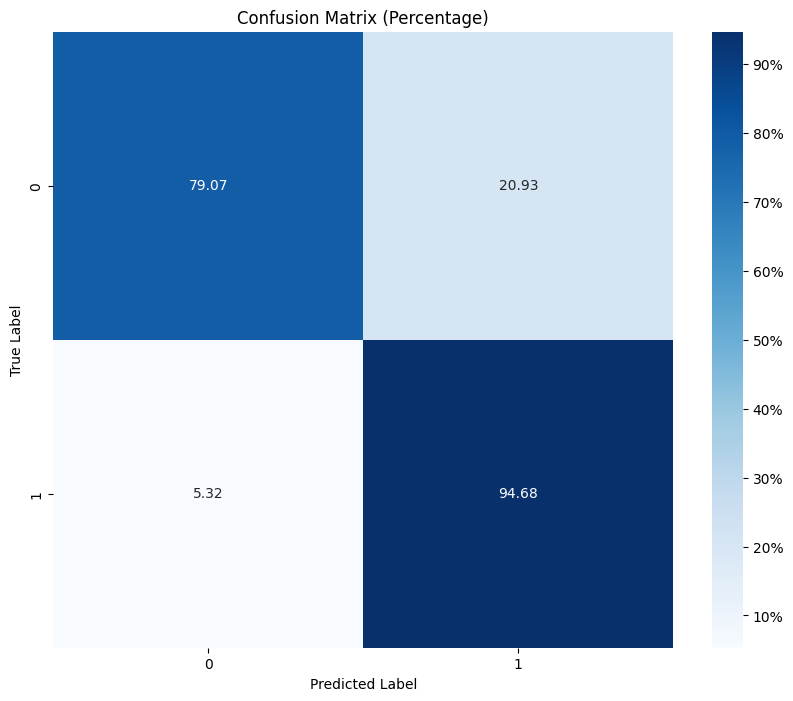

EER: 0.1512
t-DCF: 0.1511


In [16]:
# Cell 15: Reporting (Confusion Matrix, EER, t-DCF)
# Load data into variables.
discriminator.trainable = False #Freeze discriminator so it does change during the rest of the process
from sklearn.metrics import confusion_matrix, f1_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# EER and t-DCF related imports
from scipy.interpolate import interp1d

# Define t-DCF parameters (these should be set according to your task)
p_target = 0.05  # Prior probability of target speaker
c_miss = 1       # Cost of a miss (false negative)
c_false_alarm = 1 # Cost of a false alarm (false positive)

# Reset the generator to its initial state
eval_gen = data_generator(eval_data_path, batch_size=batch_size)

# Generate predictions and collect true labels
y_pred = []
y_true = []
for _ in range(eval_steps):
    batch_x, batch_y, _ = next(eval_gen)
    batch_pred = discriminator.predict(batch_x, verbose=0)
    y_pred.extend(batch_pred.flatten())
    y_true.extend(batch_y)

# Convert to numpy arrays and ensure same length
y_pred = np.array(y_pred)
y_true = np.array(y_true)
min_len = min(len(y_pred), len(y_true))
y_pred = y_pred[:min_len]
y_true = y_true[:min_len]

# Convert predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate F1 Score
f1 = f1_score(y_true, y_pred_binary)
print(f"F1 Score: {f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Convert confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualize confusion matrix as percentages
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'format': '%.0f%%' })
plt.title('Confusion Matrix (Percentage)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix.png'))  # Save confusion matrix
plt.show()

#---------------------------------------------------------------
# EER Calculation
#---------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

# Find the EER threshold
eer_threshold = thresholds[np.argmin(np.abs(fpr - (1-tpr)))]

# Calculate EER
eer = fpr[np.argmin(np.abs(fpr - (1-tpr)))]

print(f"EER: {eer:.4f}")

#---------------------------------------------------------------
# t-DCF Calculation
#---------------------------------------------------------------
def calculate_t_dcf(y_true, y_pred, p_target, c_miss, c_false_alarm, threshold):
    """
    Calculates the tuned Detection Cost Function (t-DCF).
    """
    # Apply threshold to get binary predictions
    y_pred_binary = (y_pred >= threshold).astype(int)

    # Calculate confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

    # Calculate False Alarm Rate (FAR) and Miss Rate (FR)
    far = fp / (tn + fp)
    fr = fn / (tp + fn)

    # Calculate t-DCF
    t_dcf = c_miss * p_target * fr + c_false_alarm * (1 - p_target) * far

    return t_dcf

# Calculate t-DCF using the EER threshold
t_dcf = calculate_t_dcf(y_true, y_pred, p_target, c_miss, c_false_alarm, eer_threshold)
print(f"t-DCF: {t_dcf:.4f}")